In [1]:
from autobound.causalProblem import causalProblem
from autobound.DAG import DAG
import sys
import os
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)
from src.construct_fairness_metrics import get_metric_expressions
import pandas as pd
from autobound.Query import Query
import numpy as np
import itertools
from io import StringIO
import pyomo.environ as pyo
from copy import deepcopy
import sys
from autobound.Program import pyomo_symb,mult_params_pyomo,solve1
from sklearn.linear_model import LogisticRegression
from src.utils import return_prob_df, train_fairness_classifiers, return_prob_df_unselected, calc_disparity_metric

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
sns.set_theme()
sns.set_style("whitegrid")

In [3]:
ds = np.load("/Users/njwfish/Dropbox/Testing_fairness/data/adult_new.abroca.npz")
X, y, A = ds["X"], ds["y"], ds["A"]
perm = np.random.choice(y.shape[0], size=(y.shape[0],), replace=False)
prop = int(0.5 * y.shape[0])

X_train, y_train, A_train = X[perm][:-prop], y[perm][:-prop], A[perm][:-prop]
X_test, y_test, A_test = X[perm][-prop:], y[perm][-prop:], A[perm][-prop:]

In [84]:
def prox_and_select(sens_param_range,disparity_metric,classifiers):

    # classifiers = train_fairness_classifiers(X_train,y_train,A_train,disparity_metric=disparity_metric)
    prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)

    result_list = []
    if False:
        for val in sens_param_range:
            missingness_prob=val
            proxy_nequal =val

            selec_prob_df = prob_df.copy()
            selec_prob_df["S"] = 1 
            selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]
            dag = DAG()
            dag.from_structure("A -> Y, A->P, U->P, U -> Y, V->P, V -> Z,A->Z,A->S,Y->S,W->S,W->P,Q->Z,Q->S", unob = "U,V,W,Q")
            problem = causalProblem(dag)

            numerator, denominator = get_metric_expressions(problem, disparity_metric, attribute_variable="A")   

            problem.add_prob_constraints()
            problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal),symbol="<=")
            problem.set_estimand(numerator,div=denominator)
            problem.load_data(selec_prob_df)
            program = problem.write_program()
            try:
                result = program.run_pyomo('ipopt',verbose=False)
            except:
                result = (None,None,True,True)
            result_list.append(result)
    
    result_list_select = []
    prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)

    for val in sens_param_range:
        missingness_prob = val
        if "Z" in prob_df.columns:
            prob_df["Y"] = prob_df["Z"]
            prob_df = prob_df.drop("Z",axis=1)

        selec_prob_df = prob_df.copy()
        selec_prob_df["S"] = 1 
        selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]

        dag = DAG()
        dag.from_structure("A -> Y, A->P, U->P, U -> Y, A->S, Y->S, W->S, W->P", unob = "U,W")

        problem = causalProblem(dag)

        # numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")
        numerator, denominator = get_metric_expressions(problem, disparity_metric, attribute_variable="A")   

        problem.add_prob_constraints()
        problem.set_estimand(numerator,div=denominator)
        problem.load_data(selec_prob_df)
        program = problem.write_program()
        try:
            result = program.run_pyomo('ipopt',verbose=False)
        except:
            result = (None,None,True,True)
        result_list_select.append(result)
    result_list_prox = []
    
    prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)
    for val in sens_param_range:
        proxy_nequal = val
        dag = DAG()
        # dag.from_structure("A -> Y, A->P, Y -> Z,P->Z")
        dag.from_structure("A -> Y, A->P, U->P, U -> Y, V->P, V -> Z,A->Z", unob = "U,V")
        problem = causalProblem(dag)
        problem.load_data(prob_df)
        # numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")
        numerator, denominator = get_metric_expressions(problem, disparity_metric, attribute_variable="A")   
        problem.set_estimand(numerator,div=denominator)
        problem.add_prob_constraints()
        problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal), symbol="<=")
        program = problem.write_program()
        try:
            result = program.run_pyomo('ipopt',verbose=False)
        except:
            result = (None,None,True,True)
        result_list_prox.append(result)


    return result_list,result_list_select,result_list_prox

In [5]:
metric = "FPR"
classifiers = train_fairness_classifiers(X_train,y_train,A_train,disparity_metric=metric)

/Users/njwfish/fragile.ml/.conda/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/Users/njwfish/fragile.ml/.conda/lib/python3.11

In [6]:
range_ab = np.linspace(0.1,0.1,1)
metric = "FPR"
res_old = prox_and_select(range_ab,metric,classifiers)

In [21]:
prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)

In [85]:
prox_and_select(range_ab,metric,classifiers)

([],
 [(-0.2675491034164692, 0.1949469518619199, True, True)],
 [(-0.1433321962235255, 0.18788238753323855, True, True)])

In [26]:
from autobound.causalProblem import causalProblem
from autobound.DAG import DAG
import json
from src.construct_fairness_metrics import get_metric_expressions
                     
def analyze_metric_sensitivity(
        observed_joint_table, metric, 
        dag_str, unob, constraints, cond_nodes=None, cond_node_values=1,
        attribute_node='A',outcome_node='Y',prediction_node='P',
        sensitivity_parameter_values=0.05, verbose=0, 
): 
    """
    This function runs the fair bounding analysis for a given metric on a given dataset.
    
    Args:
    - observed_joint_table: The observed joint table.
    - metric: The metric to analyze.
    - dag_str: The DAG string.
    - unob: The unobserved variable.
    - constraints: The constraints to add.
    - cond_nodes: The conditioning vertex.
    - cond_node_values: The conditioning vertex values.
    - sensitivity_parameter_value: The sensitivity parameter value.
    - verbose: The verbosity level.
    """
    dag = DAG()
    dag.from_structure(dag_str, unob = unob)
    problem = causalProblem(dag)

    # This handles conditional node logic:
    # If cond_nodes is not None, then we need to add the conditional nodes to the observed_joint_table
    # we do this by iterating over the cond_nodes and cond_node_values and adding them to the observed_joint_table
    if cond_nodes is None:
        cond_nodes = []
    else:
        if not hasattr(cond_node_values, '__iter__'):
            cond_node_values = [cond_node_values] * len(cond_nodes)
        for node, value in zip(cond_nodes, cond_node_values):
            observed_joint_table[node] = value

    if not hasattr(sensitivity_parameter_values, '__iter__'):
        sensitivity_parameter_values = [sensitivity_parameter_values] * len(constraints)

    if verbose == 1:
        print("Loading_data")
    problem.load_data(observed_joint_table, cond=cond_nodes)
    problem.add_prob_constraints()

    if verbose == 1:
        print("Collecting term")
    numerator, denominator = get_metric_expressions(
        problem,
        metric=metric, 
        attribute_variable=attribute_node,
        outcome_variable=outcome_node, 
        prediction_variable=prediction_node
    )

    if verbose == 1:
        print("Setting Estimand")
    problem.set_estimand(numerator, div=denominator)
    
    for constraint, sensitivity_parameter_value in zip(constraints, sensitivity_parameter_values):
        problem.add_natural_constraint(constraint, sensitivity_parameter_value)
    
    program = problem.write_program()
    
    if verbose == 1:
        print("Running Autobounds")
    result = program.run_pyomo('ipopt', verbose=False)

    return result

def analyze_metric_bias_sensitivity(
        probability_df, metric, bias, 
        sensitivity_parameter_values=0.05, 
        verbose=0
): 
    with open(f"../src/bias_configs/{bias}.json") as f:
        bias_config = json.load(f)

    return analyze_metric_sensitivity(
        probability_df, 
        metric=metric,
        sensitivity_parameter_values=sensitivity_parameter_values,
        verbose=verbose,
        **bias_config
    )



In [122]:
# from src.analyze_metric_sensitivity import analyze_metric_bias_sensitivity

def prox_and_select2(sens_param_range,disparity_metric,classifiers):
    prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)
    prob_df.rename(columns={"Z": "Y"},inplace=True)

    result_list = []
    for val in sens_param_range:
        missingness_prob=val
        proxy_nequal = val
        selec_prob_df = prob_df.copy()
        result = analyze_metric_bias_sensitivity(
            selec_prob_df, disparity_metric, "selection_and_proxy_y",
            sensitivity_parameter_values=[proxy_nequal, missingness_prob],
        )
        result_list.append(result)

    result_list_select = []
    for val in sens_param_range:
        missingness_prob = val
        selec_prob_df = prob_df.copy()
        result = analyze_metric_bias_sensitivity(
            selec_prob_df, disparity_metric, "selection",
            sensitivity_parameter_values=missingness_prob,
        )

        result_list_select.append(result)
        
    result_list_prox = []
    for val in sens_param_range:
        proxy_nequal = val
        result = analyze_metric_bias_sensitivity(
            prob_df, disparity_metric, "proxy_y",
            sensitivity_parameter_values=proxy_nequal,
        )
        result_list_prox.append(result)


    return result_list,result_list_select,result_list_prox

In [123]:
res_old

([(-0.40645706998675246, 0.3337596814154213, True, True)],
 [(-0.2675491034164692, 0.1949469518619199, True, True)],
 [(-0.1433321962235255, 0.18788238753323855, True, True)])

In [124]:
range_ab = np.linspace(0.1,0.1,1)
metric = "FPR"
prox_and_select2(range_ab,metric,classifiers)

([(-0.4064570887669636, 0.33375969220498797, True, True)],
 [(-0.26754912282088816, 0.1949469663652987, True, True)],
 [(-0.14333333691650815, 0.18788377346486512, True, True)])

In [74]:
range_ab = np.linspace(0.1,0.1,1)
metric = "FPR"
prox_and_select2(range_ab,metric,classifiers)

   A  Y  P      prob
0  0  0  0  0.286163
1  0  0  1  0.004275
2  0  1  0  0.002443
3  0  1  1  0.034113
4  1  0  0  0.453368
5  1  0  1  0.009161
6  1  1  0  0.017362
7  1  1  1  0.193116


([],
 [(-0.26754912282088816, 0.1949469663652987, True, True)],
 [(0.0050865804882386815, 0.005086580488814036, True, True)])

In [68]:
range_ab = np.linspace(0.1,0.1,1)
metric = "FPR"
prox_and_select2(range_ab,metric,classifiers)

   A  Z  P      prob
0  0  0  0  0.286163
1  0  0  1  0.004275
2  0  1  0  0.002443
3  0  1  1  0.034113
4  1  0  0  0.453368
5  1  0  1  0.009161
6  1  1  0  0.017362
7  1  1  1  0.193116


([],
 [(-0.26754912282088816, 0.1949469663652987, True, True)],
 [(0.0050865804882386815, 0.005086580488814036, True, True)])

In [41]:
range_ab = np.linspace(0.1,0.1,1)
metric = "FPR"
prox_and_select2(range_ab,metric,classifiers)

   A  Y  P      prob
0  0  0  0  0.286163
1  0  0  1  0.004275
2  0  1  0  0.002443
3  0  1  1  0.034113
4  1  0  0  0.453368
5  1  0  1  0.009161
6  1  1  0  0.017362
7  1  1  1  0.193116


([],
 [(-0.26754912282088816, 0.1949469663652987, True, True)],
 [(-0.14333333691650815, 0.18788377346486512, True, True)])

In [20]:
range_ab = np.linspace(0.1,0.1,1)
metric = "FPR"
prox_and_select2(range_ab,metric,classifiers)

([(-0.4064570887657915, 0.333759692189286, True, True)],
 [(-0.2675491228208914, 0.19494696636529785, True, True)],
 [(-0.143333336916508, 0.1878837734651392, True, True)])

In [8]:
range_ab = np.linspace(0.1,0.1,1)
metric = "FPR"
prox_and_select2(range_ab,metric,classifiers)

KeyboardInterrupt: 

In [ ]:
def prox_and_select(sens_param_range,disparity_metric, classifiers):

    # classifiers = train_fairness_classifiers(X_train,y_train,A_train,disparity_metric=disparity_metric)
    prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)

    result_list = []
    print("starting_joint")
    for val in sens_param_range:
        missingness_prob=val
        proxy_nequal =val

        selec_prob_df = prob_df.copy()
        selec_prob_df["S"] = 1 
        selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]
        dag = DAG()
        dag.from_structure("A -> Y, A->P, A->Z, U->P, U->Z, U->Y, U->S, Y->S, Y->P", unob = "U")
        # dag.from_structure("A -> Y, A->P, U->P, U -> Y, V->P, V -> Z,A->Z,A->S,Y->S,W->S,W->P,Q->Z,Q->S", unob = "U,V,W,Q")
        problem = causalProblem(dag)

        print("collecting term")
        numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")

        problem.add_prob_constraints()
        problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal),symbol="<=")
        problem.add_constraint(problem.query("Y(T=1)=1&Y(T=0)=0")+problem.query("Y(T=1)=0&Y(T=0)=1")- Query(proxy_nequal),symbol="<=")
        problem.set_estimand(numerator,div=denominator)
        problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))
        program = problem.write_program()
        print("running")
        try:
            result = program.run_pyomo('ipopt',verbose=False)
        except:
            result = (None,None,True,True)
        result_list.append(result)
    
    result_list_select = []
    prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)

    print("starting_select")
    for val in sens_param_range:
        missingness_prob = val
        if "Z" in prob_df.columns:
            prob_df["Y"] = prob_df["Z"]
            prob_df = prob_df.drop("Z",axis=1)

        selec_prob_df = prob_df.copy()
        selec_prob_df["S"] = 1 
        selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]

        dag = DAG()
        dag.from_structure("A -> Y, A->P, A->Z, U->P, U->Y, U->S, Y->S " ,unob="U")

        problem = causalProblem(dag)

        numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff",causal=True)

        problem.add_prob_constraints()
        problem.set_estimand(numerator,div=denominator)
        problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))
        program = problem.write_program()
        try:
            result = program.run_pyomo('ipopt',verbose=False)
        except:
            result = (None,None,True,True)
        result_list_select.append(result)
    result_list_prox = []
    
    prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)
    print("starting_proxy")
    for val in sens_param_range:
        proxy_nequal = val
        dag = DAG()
        # dag.from_structure("A -> Y, A->P, Y -> Z,P->Z")
        dag.from_structure("A -> Y, A->P, A->Z, U->P, U->Z, U->Y, Y->P ", unob = "U,V")
        problem = causalProblem(dag)
        problem.load_data(StringIO(prob_df.to_csv(index=False)))
        numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff",causal=True)
        problem.set_estimand(numerator,div=denominator)
        problem.add_prob_constraints()
        problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal),symbol="<=")
        program = problem.write_program()
        try:
            result = program.run_pyomo('ipopt',verbose=False)
        except:
            result = (None,None,True,True)
        result_list_prox.append(result)


    return result_list,result_list_select,result_list_prox

In [ ]:
def prox_and_select(sens_param_range,disparity_metric, classifiers):

    # classifiers = train_fairness_classifiers(X_train,y_train,A_train,disparity_metric=disparity_metric)
    prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)

    result_list = []
    print("starting_joint")
    for val in sens_param_range:
        missingness_prob=val
        proxy_nequal =val

        selec_prob_df = prob_df.copy()
        selec_prob_df["S"] = 1 
        selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]
        dag = DAG()
        dag.from_structure("A -> Y, A->P, A->Z, U->P, U->Z, U->Y, U->S, Y->S, Y->P", unob = "U")
        # dag.from_structure("A -> Y, A->P, U->P, U -> Y, V->P, V -> Z,A->Z,A->S,Y->S,W->S,W->P,Q->Z,Q->S", unob = "U,V,W,Q")
        problem = causalProblem(dag)

        print("collecting term")
        numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")

        problem.add_prob_constraints()
        problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal),symbol="<=")
        problem.add_constraint(problem.query("Y(T=1)=1&Y(T=0)=0")+problem.query("Y(T=1)=0&Y(T=0)=1")- Query(proxy_nequal),symbol="<=")
        problem.set_estimand(numerator,div=denominator)
        problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))
        program = problem.write_program()
        print("running")
        try:
            result = program.run_pyomo('ipopt',verbose=False)
        except:
            result = (None,None,True,True)
        result_list.append(result)
    
    result_list_select = []
    prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)

    print("starting_select")
    for val in sens_param_range:
        missingness_prob = val
        if "Z" in prob_df.columns:
            prob_df["Y"] = prob_df["Z"]
            prob_df = prob_df.drop("Z",axis=1)

        selec_prob_df = prob_df.copy()
        selec_prob_df["S"] = 1 
        selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]

        dag = DAG()
        dag.from_structure("A -> Y, A->P, A->Z, U->P, U->Y, U->S, Y->S " ,unob="U")

        problem = causalProblem(dag)

        numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff",causal=True)

        problem.add_prob_constraints()
        problem.set_estimand(numerator,div=denominator)
        problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))
        program = problem.write_program()
        try:
            result = program.run_pyomo('ipopt',verbose=False)
        except:
            result = (None,None,True,True)
        result_list_select.append(result)
    result_list_prox = []
    
    prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)
    print("starting_proxy")
    for val in sens_param_range:
        proxy_nequal = val
        dag = DAG()
        # dag.from_structure("A -> Y, A->P, Y -> Z,P->Z")
        dag.from_structure("A -> Y, A->P, A->Z, U->P, U->Z, U->Y, Y->P ", unob = "U,V")
        problem = causalProblem(dag)
        problem.load_data(StringIO(prob_df.to_csv(index=False)))
        numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff",causal=True)
        problem.set_estimand(numerator,div=denominator)
        problem.add_prob_constraints()
        problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal),symbol="<=")
        program = problem.write_program()
        try:
            result = program.run_pyomo('ipopt',verbose=False)
        except:
            result = (None,None,True,True)
        result_list_prox.append(result)


    return result_list,result_list_select,result_list_prox

In [7]:
classifiers = train_fairness_classifiers(X_train,y_train,A_train,disparity_metric="EO_max")

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

KeyboardInterrupt: 

In [ ]:
y_hat = classifiers[0][0].predict(X_test)

TypeError: 'LogisticRegression' object is not subscriptable

In [8]:
classifiers = train_fairness_classifiers(X_train,y_train,A_train,disparity_metric=disparity_metric)
prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

In [ ]:
calc_disparity_metric(y_test,classifiers[0].predict(X_test),A_test,disparity_metric="EO_max")

0.01681421474029353

In [ ]:
prob_df.to_csv("/Users/jake/Python/Testing_fairness/autobounds_data/EO_model.csv")

In [ ]:
def prox_and_select_heatmap(sens_param_range):
    result_matrix = np.zeros((len(sens_param_range),len(sens_param_range)))
    print("starting_joint")
    for i,missingness_prob in enumerate(sens_param_range):
        for j,proxy_nequal in  enumerate(sens_param_range):
            disparity_metric_max = 0
            for disparity_metric in ["FPR","FNR"]:
                selec_prob_df = prob_df.copy()
                selec_prob_df["S"] = 1 
                selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]
                dag = DAG()
                # dag.from_structure("A -> Y, A->P, A->Z,A->S, U->P, U->Z, U->Y, U->S, Y->S, Y->Z", unob = "U")
                dag.from_structure("A -> Y, A->P, U->P, U -> Y, V->P, V -> Z,A->Z,A->S,Y->S,W->S,W->P, Q->Z, Q->S", unob = "U,V,W,Q")
                problem = causalProblem(dag)

                print("collecting term")
                numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")

                problem.add_prob_constraints()
                problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal),symbol="<=")
                problem.set_estimand(numerator,div=denominator)
                problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))
                program = problem.write_program()
                print("running")
                try:
                    result = program.run_pyomo('ipopt',verbose=False)
                except:
                    result = (None,None,True,True)
                disparity_metric_max = max(abs(result[0]),abs(result[1]),disparity_metric_max)
            result_matrix[i,j] = disparity_metric_max

    return result_matrix

In [9]:
range_ab = np.linspace(0.0,0.05,6)
missingness_prob = 0.05
proxy_nequal = 0.05

In [19]:
selec_prob_df = prob_df.copy()
selec_prob_df["S"] = 1 
selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]
dag = DAG()
# dag.from_structure("A -> Y, A->P, U->P, U -> Y, V->P, V -> Z,A->Z,A->S,Y->S,W->S,W->P,Q->Z,Q->S", unob = "U,V,W,Q")
dag.from_structure("A -> Y, A->P, A->Z, A->S, U->P, U->Z, U->S, U->Y ,Y->S,Y->Z", unob = "U")
problem = causalProblem(dag)

print("collecting term")
numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")

problem.add_prob_constraints()
problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal),symbol="<=")
print("term")
problem.set_estimand(numerator,div=denominator)
problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))
program = problem.write_program()
print("running")
result = program.run_pyomo('ipopt',verbose=True)

collecting term
setting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'


KeyboardInterrupt: 

In [16]:
len(program.constraints[3])

5571329

In [ ]:
len(problem.parameters)

4098

In [ ]:
result

(-0.3095251056019839, 0.3503195690731475, True, True)

In [ ]:
sens_param_range = range_ab
result_matrix = np.zeros((len(sens_param_range),len(sens_param_range)))
print("starting_joint")
for i, missingness_prob in enumerate(sens_param_range):
    for j, proxy_nequal in  enumerate(sens_param_range):
        print(i,j)
        disparity_metric_max = 0
        for disparity_metric in ["FPR", "FNR"]:
            selec_prob_df = prob_df.copy()
            selec_prob_df["S"] = 1 
            selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]
            dag = DAG()
            dag.from_structure("A -> Y, A->P, U->P, U -> Y, V->P, V -> Z,A->Z,A->S,Y->S,W->S,W->P,Q->Z,Q->S", unob = "U,V,W,Q")
            problem = causalProblem(dag)

            print("collecting term")
            numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")

            problem.add_prob_constraints()
            problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal),symbol="<=")
            problem.set_estimand(numerator,div=denominator)
            problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))
            program = problem.write_program()
            print("running")
            try:
                result = program.run_pyomo('ipopt',verbose=False)
            except:
                result = (None,None,True,True)
            disparity_metric_max = max(abs(result[0]),abs(result[1]),disparity_metric_max)
        result_matrix[i, j] = disparity_metric_max

starting_joint
0 0
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
0 1
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
0 2
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
0 3
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
0 4
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
0 5
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
1 0
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
1 1
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
1 2
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
1 3
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
1 4
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
1 5
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
2 0
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
2 1
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
2 2
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
2 3
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
2 4
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
2 5
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
3 0
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
3 1
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
3 2
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
3 3
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
3 4
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
3 5
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
4 0
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
4 1
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
4 2
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
4 3
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
4 4
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
4 5
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
5 0
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
5 1
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
5 2
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
5 3
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
5 4
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
5 5
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running


In [ ]:
result_matrix

array([[0.01683999, 0.20540843, 0.33653864, 0.42806205, 0.97012138,
        1.        ],
       [0.20701757, 0.33870976, 0.43040671, 0.70759607, 0.9733542 ,
        1.        ],
       [0.34090922, 0.43277729, 0.56541257, 0.80984091, 0.97636788,
        1.        ],
       [0.43517423, 0.52454302, 0.65352775, 0.85596872, 1.        ,
        1.        ],
       [0.5051454 , 0.59201963, 0.71062443, 0.88222818, 0.98181788,
        1.        ],
       [0.5591361 , 0.64201304, 0.75063003, 0.89918315, 0.98428993,
        1.        ]])

In [ ]:
result_matrix = np.load('/Users/jake/Python/Testing_fairness/autobounds_data/result.npy')

In [ ]:
result_matrix

array([[0.01683999, 0.20540843, 0.33653864, 0.42806205, 0.97012138,
        1.        ],
       [0.20701757, 0.33870976, 0.43040671, 0.70759607, 0.9733542 ,
        1.        ],
       [0.34090922, 0.43277729, 0.56541257, 0.80984091, 0.97636788,
        1.        ],
       [0.43517423, 0.52454302, 0.65352775, 0.85596872, 1.        ,
        1.        ],
       [0.5051454 , 0.59201963, 0.71062443, 0.88222818, 0.98181788,
        1.        ],
       [0.5591361 , 0.64201304, 0.75063003, 0.89918315, 0.98428993,
        1.        ]])

In [ ]:
with open('/Users/jake/Python/Testing_fairness/autobounds_data/result.npy', 'wb') as f:
    np.save(f, result_matrix)

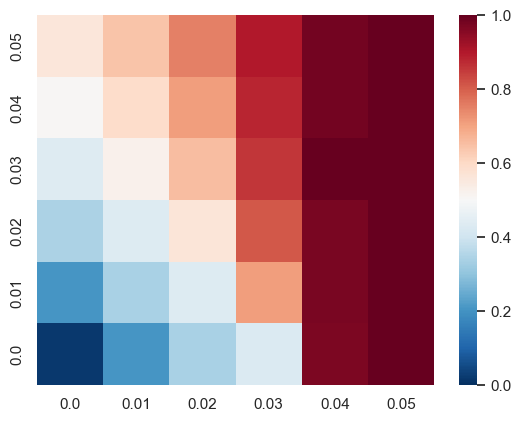

In [ ]:
ax = sns.heatmap(result_matrix, xticklabels=range_ab, yticklabels=range_ab, cmap="RdBu_r", vmin=0)
ax.invert_yaxis()
ax.set_xlabel(r"$P(S=0)$")
ax.set_ylabel(r"$P(Y_P\neq Y)$")
ax.set_title("Upper Bound on Equalised Odds by Degree of Bias")
# ax.invert_xaxis()

In [ ]:
ax.set_xlabel(r"$P(S=0)$")
ax.set_ylabel(r"$P(Y_P\neq Y)$")
ax.set_title("Upper Bound on Equalised Odds by Degree of Bias")

Text(0.5, 1.0, 'Upper Bound on Equalised Odds by Degree of Bias')

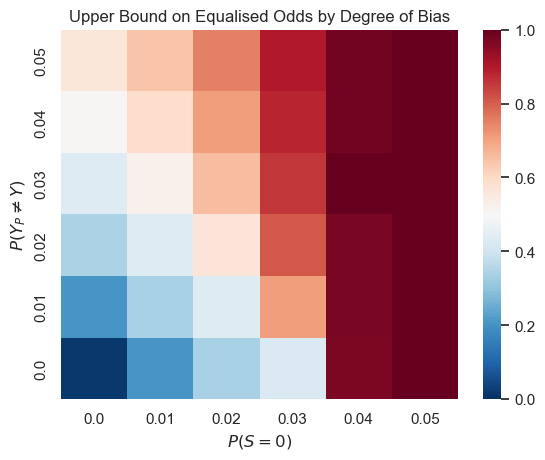

In [ ]:
ax.figure

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

<Axes: ylabel='Density'>

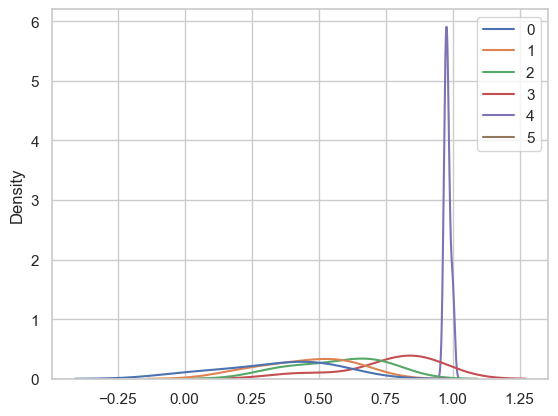

In [ ]:
sns.kdeplot(result_matrix)

In [ ]:
def prox_and_ECP_heatmap(sens_param_range):
    result_matrix = np.zeros((len(sens_param_range),len(sens_param_range)))
    print("starting_joint")
    for i,ecd_param in enumerate(sens_param_range):
        for j,proxy_nequal in  enumerate(sens_param_range):
            disparity_metric_max = 0
            for disparity_metric in ["FPR","FNR"]:
                # selec_prob_df = prob_df.copy()
                # selec_prob_df["S"] = 1 
                # selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]
                dag = DAG()
                dag.from_structure("A -> Y, A->P, A->Z, U->P, U->Z, U->Y, U->S, Y->S, Y->Z", unob = "U")
                
                problem = causalProblem(dag)

                print("collecting term")
                numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")

                problem.add_prob_constraints()
                problem.add_constraint(problem.query("Y(T=1)=0&Y(T=0)=1"),symbol="==")
                problem.add_constraint(problem.query("Y(T=1)=1")-problem.query("Y(T=0)=1")- Query(ecd_param),symbol="<=")
                problem.add_constraint(problem.query("Y=1&Z=0")+problem.query("Y=0&Z=1") - Query(proxy_nequal),symbol="<=")
                problem.set_estimand(numerator,div=denominator)
                problem.load_data(StringIO(selec_prob_df.to_csv(index=False)))
                program = problem.write_program()
                print("running")
                try:
                    result = program.run_pyomo('ipopt',verbose=False)
                except:
                    result = (None,None,True,True)
                disparity_metric_max = max(abs(result[0]),abs(result[1]),disparity_metric_max)
            result_matrix[i,j] = disparity_metric_max

    return result_matrix

In [ ]:
range_ab

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05])

In [ ]:
prox_and_select_heatmap(range_ab)

starting_joint
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running


TypeError: bad operand type for abs(): 'NoneType'

In [ ]:
range_ab

array([0.05])

In [ ]:
range_ab = np.linspace(0.1,0.1,1)
metric = "FPR"
prox_and_select(range_ab,metric)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

starting_joint
collecting term


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

running
ERROR: Rule failed when generating expression for Constraint c3 with index
None: ValueError: Invalid constraint expression. The constraint expression
resolved to a trivial Boolean (True) instead of a Pyomo object. Please modify
your rule to return Constraint.Feasible instead of True.

    Error thrown for Constraint 'c3'
ERROR: Constructing component 'c3' from data=None failed: ValueError: Invalid
constraint expression. The constraint expression resolved to a trivial Boolean
(True) instead of a Pyomo object. Please modify your rule to return
Constraint.Feasible instead of True.

    Error thrown for Constraint 'c3'
starting_select


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

starting_proxy


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

([(None, None, True, True)],
 [(-0.2246192114869054, 0.2907213336468359, True, True)],
 [(-0.32528788149675075, 0.30114013964533387, True, True)])

In [5]:
# metrics = ["FPR"]
metrics = ["FNR","PPP","NPP","FPR"]
results_dict = {}
range_ab = np.linspace(0,0.05,5)
for i,metric in enumerate(metrics):
    print(i)
    results_dict[metric] = prox_and_select(range_ab,metric)

0


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

1


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

2


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

3


/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

In [ ]:
metrics = ["FPR","FNR","PPP","NPP"]


In [ ]:
# result_list_plus = [(x[0]+y[0],x[1]+y[1]) for x,y in zip(result_list_prox,result_list_select)]

In [6]:
legend_labels = ["Proxy and Selection combined","Selection","Proxy","Proxy + Selection"]

In [11]:
results_dict["NPP"]

([(0.002230170033315817, 0.002289100590950524, True, True),
  (-0.08021892891286518, 0.06289354700962899, True, True),
  (-0.15794958444378887, 0.11572772180857918, True, True),
  (-0.2313555677648228, 0.16702041339379695, True, True),
  (-0.3007880260131166, 0.21683811299998265, True, True)],
 [(0.002259156001102706, 0.002265383534078563, True, True),
  (-0.03860237909452831, 0.02906372695895783, True, True),
  (-0.07712543998915228, 0.05506863328664458, True, True),
  (-0.11350518218837079, 0.08031481893104801, True, True),
  (-0.14791563704091837, 0.10483501118957013, True, True)],
 [(0.00226212814489758, 0.002264167290250497, True, True),
  (-0.040589672758499507, 0.03618336385493389, True, True),
  (-0.08344147476237283, 0.06393907869408526, True, True),
  (-0.12629327676625857, 0.09169479353326851, True, True),
  (-0.16914507877014573, 0.11945050837248226, True, True)])

In [12]:
results_dict["FPR"]

([(0.009491959075197167, 0.009550675379032147, True, True),
  (-0.07000864879546548, 0.06684717453118603, True, True),
  (-0.13923758150237614, 0.11442802687183369, True, True),
  (-0.20000499667329527, 0.15845253042514645, True, True),
  (-0.24749943312718006, 0.1993050441951928, True, True)],
 [(0.00952100095564799, 0.009527206119774714, True, True),
  (-0.03190290897196988, 0.03553365069124121, True, True),
  (-0.07091991931947632, 0.06080504990008632, True, True),
  (-0.1077338800254176, 0.08537212486950999, True, True),
  (-0.14252625687845605, 0.10926391563309801, True, True)],
 [(0.009524016414941201, 0.009525032334677136, True, True),
  (-0.03140379191432058, 0.04140709310110085, True, True),
  (-0.06906665496493068, 0.06621805672776059, True, True),
  (-0.1019116289489912, 0.08977707516558509, True, True),
  (-0.1208707115606443, 0.11217657503828987, True, True)])

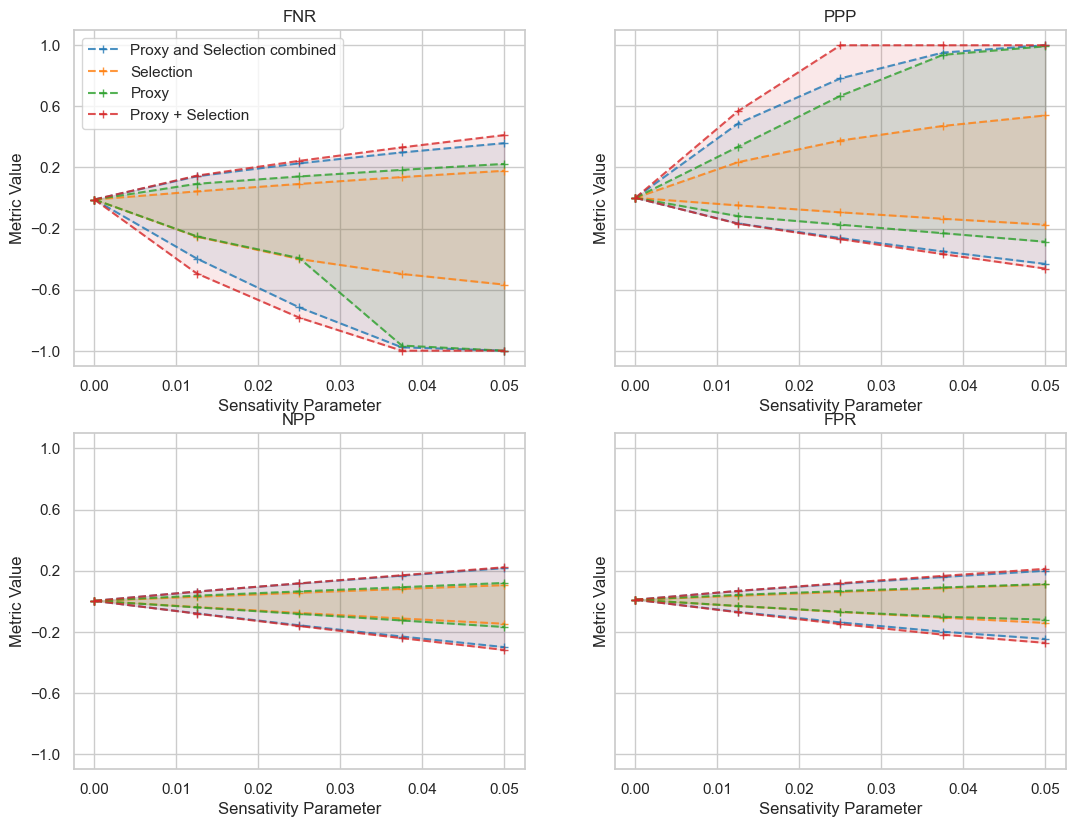

In [10]:
fig, ax = plt.subplots(nrows=2,ncols=2,sharey=True,figsize= (25.6/2,9.6 ))
ax = ax.reshape(4)

range_ab = np.linspace(0,0.05,5)
colours = sns.color_palette("tab10", 4)
subfig_num = [[0,0],[0,1],[1,0],[1,1]]
# results = [result_list[1:],result_list_prox[1:],result_list_select[1:]]
# results = [r0_list+rl for rl in results]

lines = []
for i, metric in enumerate(metrics):

    results = list(results_dict[metric])
    metric_val = results[1][0][0]
    result_list_plus = [(max(x[0]+y[0]-metric_val,-1),min(x[1]+y[1]-metric_val,1)) for x,y in zip(results[1],results[2])]
    results.append(result_list_plus)
    lines = []
    for j,r_list in enumerate(results):
        lower_results = []
        upper_results = []
        for val in r_list:
            lower_results.append(val[0])
            upper_results.append(val[1])
        ax[i].fill_between(range_ab, lower_results, upper_results, alpha=.1,color = colours[j])
        line,  = ax[i].plot(range_ab, upper_results, ls='--', marker='+', alpha=0.8,color=colours[j])
        ax[i].plot(range_ab, lower_results, ls='--',marker='+', alpha=0.8,color=colours[j])
        lines.append(line)
        ax[i].set_yticks(np.arange(-1, 1.2, 0.4))
        ax[i].set_xlabel("Sensativity Parameter")
        ax[i].set_ylabel("Metric Value")
        ax[i].set_title(metric)


ax[0].legend(handles = lines,labels = legend_labels,loc = "upper left")



In [ ]:
def selective_labels(selective_prop,disparity_metric):

    truth_vec_train = (LR_classifier.predict_proba(X_train)[:,1]>selective_prop)
    truth_vec_test = (LR_classifier.predict_proba(X_train)[:,1]>selective_prop)

    X_train_subset,y_train_subset,A_train_subset = X_train[truth_vec_train], y_train[truth_vec_train],A_train[truth_vec_train] 
    X_test_subset,y_test_subset,A_test_subset = X_test[truth_vec_test], y_test[truth_vec_test],A_test[truth_vec_test] 

    classifiers = train_fairness_classifiers(X_train_subset,y_train_subset,A_train_subset,disparity_metric=disparity_metric)
    pred_df = return_prob_df(classifiers[0],X_test_subset,y_test_subset,A_test_subset)
    pred_df["S"] = 1
    pred_df["Y"] = pred_df["Z"]
    prob_df = pred_df.drop("Z",axis=1)

    unselect_pred_df = return_prob_df_unselected(classifiers[0],X_test,y_test,A_test,truth_vec_test)
    dag = DAG()        
    dag.from_structure("A -> S, A -> Y,A -> P, U->P,V->P, V->S,Y->S, U->Y " ,unob="U,V")
    # dag.from_structure("A -> S, A -> Y,A -> P, V->S,Y->S, U->Y " ,unob="U,V")
    problem = causalProblem(dag)
    problem.load_data(StringIO(pred_df.to_csv(index=False)),cond=["S"])
    problem.load_data(StringIO(unselect_pred_df.to_csv(index=False)))
    numerator,denominator = get_numerator_denominator(problem,disparity_metric,"diff")
    problem.add_prob_constraints()
    problem.set_estimand(numerator,div=denominator)
    program = problem.write_program()
    result = program.run_pyomo(verbose=False)
    metric_val = calc_disparity_metric(y_test_subset,classifiers[0].predict(X_test_subset),A_test_subset,disparity_metric=disparity_metric)
    return result, metric_val ,classifiers[0]

In [ ]:
LR_classifier = LogisticRegression()
LR_classifier.fit(X_train,y_train)

metrics = ["FPR","FNR","PPP","NPP"] 
selective_prop = 0.2
results_dict_selective = {}
true_val = {}

for metric in metrics:
    results_dict_selective[metric] = selective_labels(selective_prop,metric)
    true_val[metric] = calc_disparity_metric(y_test,results_dict_selective[metric][2].predict(X_test), A_test, disparity_metric=metric)

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

<ErrorbarContainer object of 3 artists>

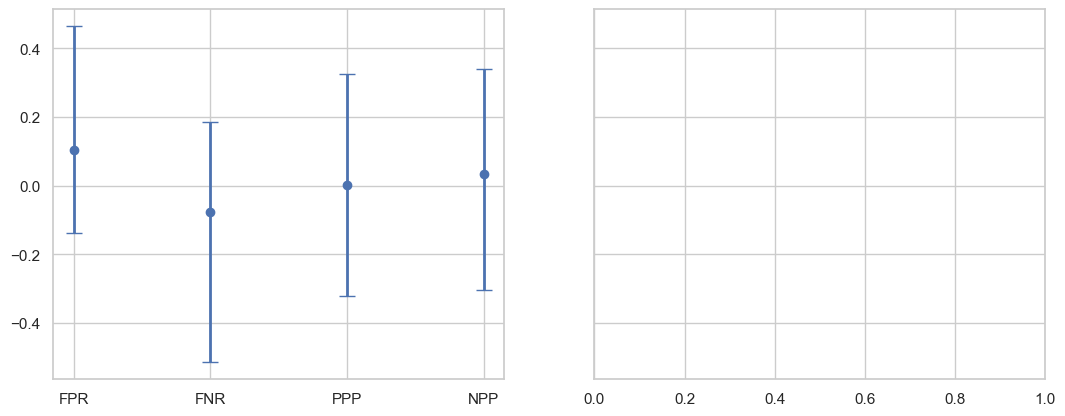

In [ ]:
colours = sns.color_palette("tab10", 4)
fig, ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize= (25.6/2,4.8 ))

ax[0].errorbar(metrics,[results_dict_selective[x][1] for x in metrics],[[results_dict_selective[x][1] - results_dict_selective[x][0][0] for x in metrics],[results_dict_selective[x][0][1]-results_dict_selective[x][1] for x in metrics]],fmt='o', linewidth=2, capsize=6)


In [ ]:
list(results_dict["NPP"])[0]

[(-0.013475891958753466, -0.013319835162956695, True, True),
 (-0.24135810567753477, 0.30249533950811885, True, True),
 (-0.3264268255639704, 0.5326611648493004, True, True),
 (-0.4067736217247156, 0.7078588318690497, True, True),
 (-0.48278102941014606, 0.8551928039185088, True, True),
 (-0.5547913491934063, 0.9095293570279253, True, True)]

In [ ]:
colours[0],colours[1] = colours[1],colours[0]

Text(0, 0.5, 'Metric Value')

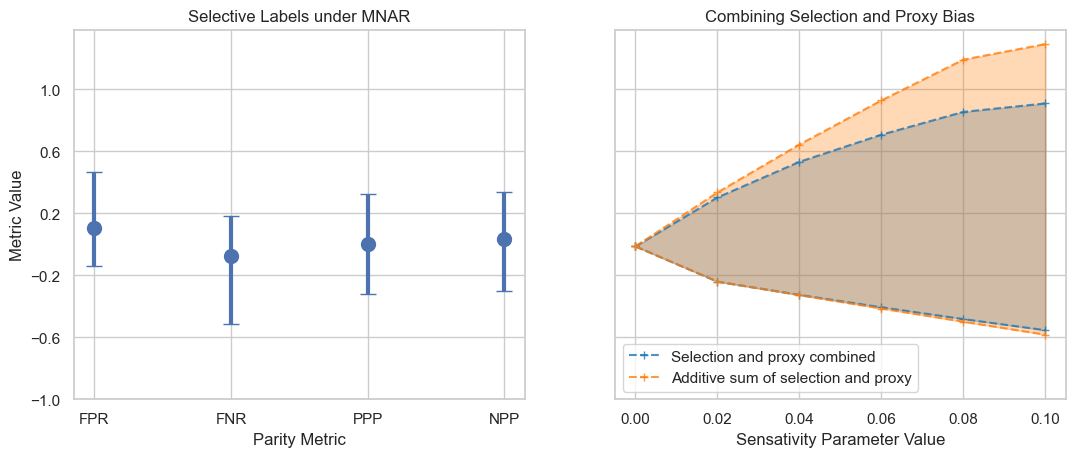

In [ ]:

fig, ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize= (25.6/2,4.8 ))

ax[0].errorbar(metrics,[results_dict_selective[x][1] for x in metrics],[[results_dict_selective[x][1] - results_dict_selective[x][0][0] for x in metrics],[results_dict_selective[x][0][1]-results_dict_selective[x][1] for x in metrics]],fmt='o', linewidth=3,markersize='10', capsize=6)
legend_labels = ["Selection and proxy combined","Additive sum of selection and proxy"]
metric = "NPP"
i = 1
results = list(results_dict[metric])
metric_val = results[1][0][0]
result_list_plus = [(x[0]+y[0]-metric_val,x[1]+y[1]-metric_val) for x,y in zip(results[1],results[2])]
results.append(result_list_plus)
results = [results[0]] + [results[-1]]
lines = []
for j,r_list in enumerate(results):
    lower_results = []
    upper_results = []
    for val in r_list:
        lower_results.append(val[0])
        upper_results.append(val[1])

    ax[i].fill_between(range_ab, lower_results, upper_results, alpha=0.3,color = colours[j])
    line,  = ax[i].plot(range_ab, upper_results, ls='--', marker='+', alpha=0.8,color=colours[j])
    ax[i].plot(range_ab, lower_results, ls='--',marker='+', alpha=0.8,color=colours[j])
    lines.append(line)

ax[0].set_title("Selective Labels under MNAR")
ax[1].set_title("Combining Selection and Proxy Bias")
ax[1].legend(handles = lines,labels = legend_labels)
ax[1].set_yticks(np.arange(-1, 1.2, 0.4))
ax[0].set_xlabel("Parity Metric")
ax[1].set_xlabel("Sensativity Parameter Value")
ax[0].set_ylabel("Metric Value")

In [ ]:
ax[0].set_leg

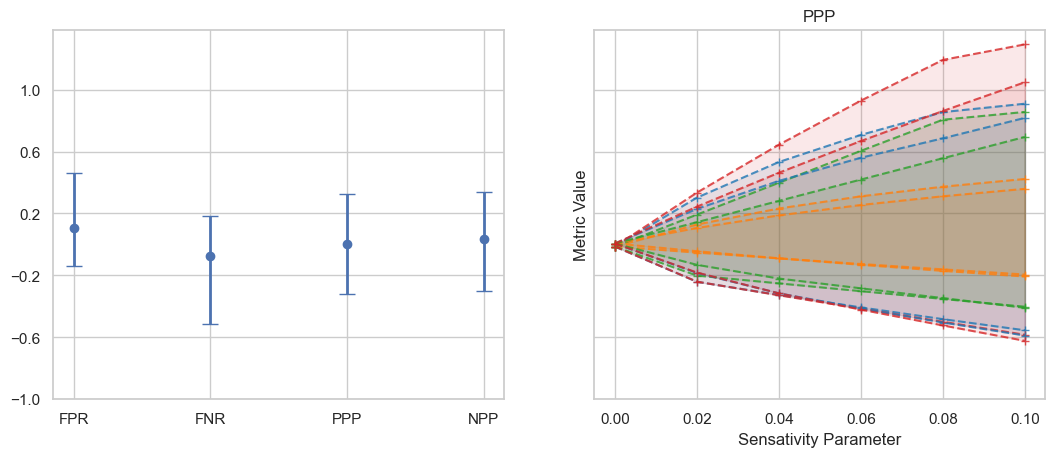

In [ ]:
fig

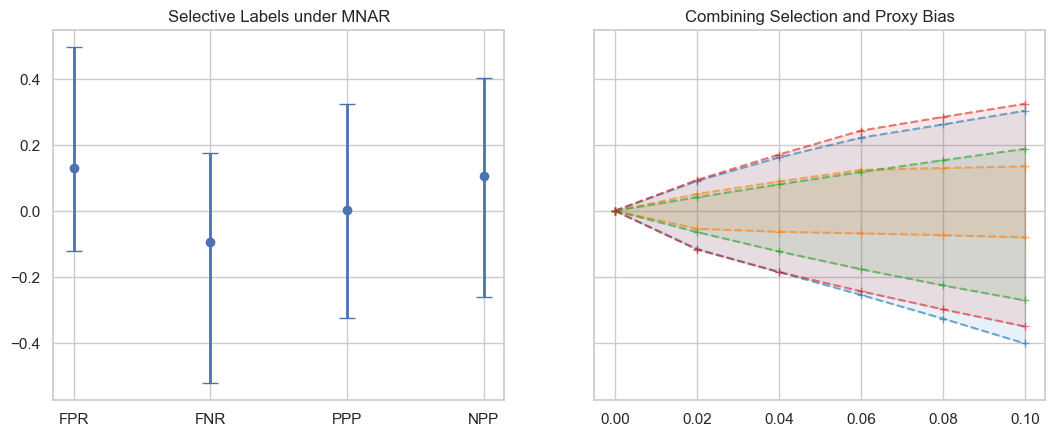

In [ ]:
fig

In [ ]:
dag = DAG()
dag.from_structure("A -> Y, A -> P, A -> S, Y -> P, Y -> S, U -> S,U -> P",unob="U")
problem = causalProblem(dag)
problem.load_data('autobounds_data/selected_data.csv',cond=["S"])
problem.load_data('autobounds_data/unselected_data.csv')
numerator,denominator = get_numerator_denominator(problem,metric,comparison)
problem.set_estimand( problem.query("P=0"))
problem.add_prob_constraints()
program = problem.write_program()
program.run_pyomo()

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query_cond = [ f'{row_cond.index[j]}={int(row_cond[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

Ipopt 3.12.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3385
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1024

Total number of variables............................:      261
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      261
                     variables with only upper bounds:        0
Total number of equality constraints.................:       19
Total number of in

(0.4530667811067756, 0.4530504627300316, False, False)

In [ ]:
prob_df = pd.read_csv("autobounds_data/trained_models/proxy_examples_FNR/compas.csv")

In [ ]:
prob_df

,A,Z,P,prob
0,0,0,0,0.224706
1,0,0,1,0.067450
2,0,1,0,0.150057
3,0,1,1,0.156499
4,1,0,0,0.179235
5,1,0,1,0.067450
6,1,1,0,0.084881
7,1,1,1,0.069723


In [ ]:
prob_df["prob"][(prob_df["A"] == 0)  & (prob_df["Z"] == 1) & (prob_df["P"] == 0)].item()

0.1500568397120121

In [ ]:
torch.set_printoptions(precision=6)

In [ ]:
def get_p_vector_torch(df):
    p = torch.zeros(2,2,2)
    for i,j,k in itertools.product(range(2),range(2),range(2)):
        p[i,j,k] =   df["prob"][(df["A"] == i)  & (df["Z"] == j) & (df["P"] == k)].item()
    return p

In [ ]:
prob_df

,A,Z,P,prob
0,0,0,0,0.224706
1,0,0,1,0.067450
2,0,1,0,0.150057
3,0,1,1,0.156499
4,1,0,0,0.179235
5,1,0,1,0.067450
6,1,1,0,0.084881
7,1,1,1,0.069723


In [ ]:
prob_vec = get_p_vector_torch(prob_df)

In [ ]:
prob_vec[1,0]+prob_vec[1,1]

tensor([0.264115, 0.137173])

In [ ]:
p = prob_vec[0,:,:]

In [ ]:
p[1,0]/(p[1,1] + p[1,0])

tensor(0.489493)

In [ ]:
(0.5>1)*10

0

In [ ]:
alpha = 0.1

In [ ]:
p

tensor([[0.224706, 0.067450],
        [0.150057, 0.156499]])

In [ ]:
def prox_sens_fogliatio(prob_vec,alpha = 0.05,group=0,disparity_metric = "FPR",constrained = False):

    p = prob_vec[group,:,:]

    if disparity_metric == "FPR":
        if not constrained:
            metric_val = ((p[0,1]-alpha)/(p[0,1]+p[0,0]-alpha),(p[0,1])/(p[0,1]+p[0,0]-alpha))
        else:
            metric_val = ( ( p[0,1]* (p[1,0] + p[1,1] ) - alpha * p[1,0] ) / ((p[0,1]+p[0,0]-alpha)*(p[1,0]+p[1,1])),(p[0,1])/(p[0,1]+p[0,0]))

    if disparity_metric == "FNR":
        if not constrained:
            if alpha<p[0,1]:
                metric_val = ((p[1,0])/(p[1,0]+p[1,1]+alpha),(p[1,0]+alpha)/(p[1,0]+p[1,1]+alpha))
            else:
                metric_val = ((p[1,0])/(p[1,0]+p[1,1]+p[0,1]),(p[1,0]+alpha)/(p[1,0]+p[1,1]+alpha))
        else:
            metric_val = metric_val = ((p[1,0])/(p[1,0]+p[1,1]),(p[1,1])/(p[1,0]+p[1,1]))
        
    
    if disparity_metric == "PPV":
        if not constrained:
            metric_val = ((p[1,1])/(p[0,1]+p[1,1]),(p[1,1]+alpha)/(p[0,1]+p[1,1]))
        else: 
            metric_val = ((p[1,1])/(p[0,1]+p[1,1]),(p[1,1]+alpha*((p[1,0])/(p[1,0]+p[1,1]) ))/(p[0,1]+p[1,1]))

    

    
    return (max(0,metric_val[0]),min(1,metric_val[1]))


In [ ]:
def autobounds_prox_sens_fogliatio(prob_df,alpha = 0.05,group=0,disparity_metric = "FPR",optimiser="ipopt",dag_type ="unrestricted"):
    op_group = 1 -group
    proxy_equal = 1-alpha
    dag = DAG()
    # dag.from_structure("A -> Y, A->P, Y -> Z,P->Z")
    if dag_type == "unrestricted":
        dag.from_structure("A -> Y, A->P, Y -> Z, U->P, U -> Y, V->P, V -> Z,A->Z", unob = "U,V")
    else:
        dag.from_structure("A -> Y, A->P, Y -> Z, U->P, U -> Y,A->Z", unob = "U")
    problem = causalProblem(dag)
    problem.load_data(StringIO(prob_df.to_csv(index=False)))
    numerator,denominator = get_numerator_denominator_fogliato(problem,metric=disparity_metric,group=group)
    problem.set_estimand(numerator,div=denominator)
    # problem.set_estimand(problem.query(f"Y=1&Z=0&A={group}&P=0"))
    problem.add_constraint(problem.query("Y=0&Z=1"),symbol="==")
    # problem.add_constraint(problem.query(f"Y=1&Z=0&A={op_group}"),symbol="==")
    problem.add_constraint(problem.query(f"Y=1&Z=0&A={group}") - Query(alpha),symbol="<=")
    program = problem.write_program()
    if optimiser=="ipopt":
        result = program.run_pyomo('ipopt',verbose=False)
    if optimiser=="couenne":
        M = pyo.ConcreteModel()
        solver = pyo.SolverFactory('couenne')
        for p in program.parameters:
            if p != 'objvar':
                setattr(M, p, pyo.Var(bounds = (0,1)))
            else:
                setattr(M, p, pyo.Var())
        # Next loop is not elegant, needs refactoring
        for i, c in enumerate(program.constraints):
            setattr(M, 'c' + str(i), 
                    pyo.Constraint(expr = 
                        pyomo_symb[c[-1][0]](sum([ mult_params_pyomo(program.parameters, k, M ) for k in c[:-1] ]), 0)
                    )
            )
        program.M_upper = deepcopy(M)
        program.M_lower = deepcopy(M)
        program.M_upper.obj = pyo.Objective(expr = program.M_upper.objvar, sense = pyo.maximize)
        program.M_lower.obj = pyo.Objective(expr = program.M_lower.objvar, sense = pyo.minimize)
        solve1(solver,program.M_lower,'lower',True)
        result = None
    return result

In [ ]:
prox_sens_fogliatio(prob_vec,alpha = 0.08,group=0,disparity_metric = "FNR")

(tensor(0.401216), tensor(0.595146))

In [ ]:
autobounds_prox_sens_fogliatio(prob_df,alpha = 0.1,group=0,disparity_metric = "FPR",optimiser="ipopt")

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

NameError: name 'get_numerator_denominator_fogliato' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
sns.set_theme()
sns.set_style("whitegrid")

In [ ]:
metrics = ["FPR","FNR","PPV"]

In [ ]:
colours = sns.color_palette("tab10", 3)

In [ ]:
colours

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

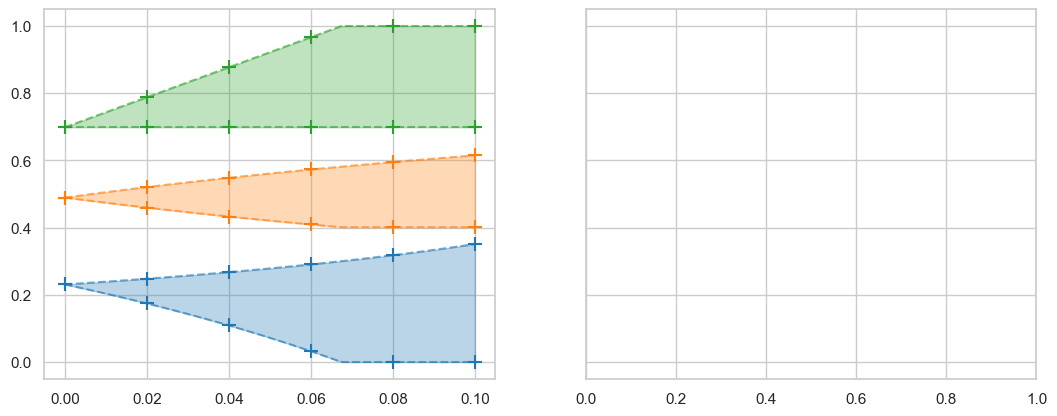

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize= (25.6/2,4.8 ))

range_curve = np.linspace(0,0.1,200)
range_ab = np.linspace(0,0.1,6)
for i,metric in enumerate(metrics):
    lower_results = []
    upper_results = []
    for val in range_curve:
        sens_results = prox_sens_fogliatio(prob_vec,alpha = val,group=0,disparity_metric = metric)
        lower_results.append(sens_results[0])
        upper_results.append(sens_results[1])
    ax[0].fill_between(range_curve, lower_results, upper_results, alpha=.3,color = colours[i])
    ax[0].plot(range_curve, upper_results, ls='--', alpha=.6,color=colours[i])
    ax[0].plot(range_curve, lower_results, ls='--', alpha=.6,color=colours[i])
    
    lower_results = []
    upper_results = []

    for val in range_ab:
        sens_results = autobounds_prox_sens_fogliatio(prob_df,alpha = val,group=0,disparity_metric = metric)
        lower_results.append(sens_results[0])
        upper_results.append(sens_results[1])

    ax[0].scatter(range_ab, upper_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])
    ax[0].scatter(range_ab, lower_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])




In [ ]:
metrics = ["FPR","FNR","PPV"]
range_curve = np.linspace(0,0.1,200)
range_ab = np.linspace(0,0.1,8)
for i,metric in enumerate(metrics):
    lower_results = []
    upper_results = []

    for val in range_curve:
        sens_results = prox_sens_fogliatio(prob_vec,alpha = val,group=0,disparity_metric = metric,constrained=True)
        lower_results.append(sens_results[0])
        upper_results.append(sens_results[1])
        
    if metric == "FNR":
        ax[1].plot(range_curve, lower_results, ls='--', alpha=.6,color=colours[i])
    else:
        ax[1].fill_between(range_curve, lower_results, upper_results, alpha=.3,color = colours[i])
        ax[1].plot(range_curve, upper_results, ls='--', alpha=.6,color=colours[i])
        ax[1].plot(range_curve, lower_results, ls='--', alpha=.6,color=colours[i])
    
    lower_results = []
    upper_results = []

    for val in range_ab:
        sens_results = autobounds_prox_sens_fogliatio(prob_df,alpha = val,group=0,disparity_metric = metric,dag_type="restriced")
        lower_results.append(sens_results[0])
        upper_results.append(sens_results[1])

    ax[1].scatter(range_ab, upper_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])
    ax[1].scatter(range_ab, lower_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

In [ ]:
range_ab

array([0.        , 0.01428571, 0.02857143, 0.04285714, 0.05714286,
       0.07142857, 0.08571429, 0.1       ])

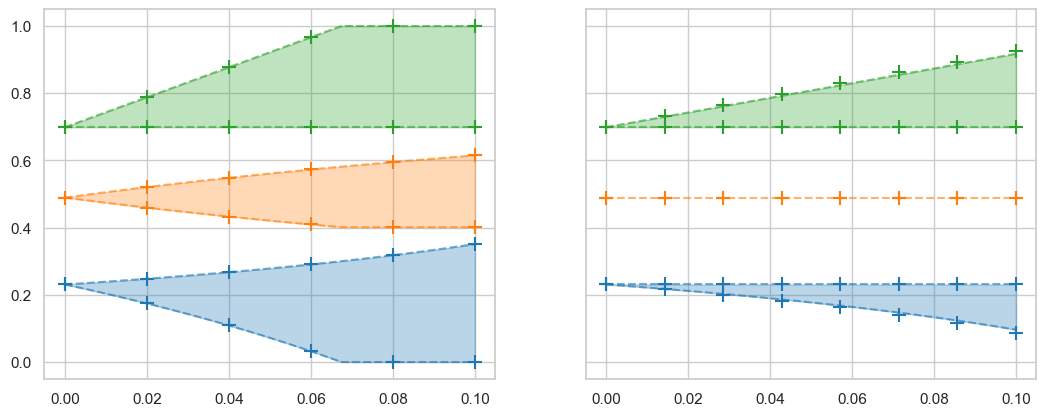

In [ ]:
fig

In [ ]:
legend_elements = [
                   Patch(facecolor=colours[0],
                         label='Color Patch'),
                     Patch(facecolor=colours[1],
                         label='Color Patch'),
                     Patch(facecolor=colours[2],
                         label='Color Patch'),
                         Line2D([0], [0], color='k', lw=2,ls="--", label='Line'),
                   Line2D([0], [0], marker='+', color='k', label='Scatter',
                          markerfacecolor='b', markersize=15),]
legend_titles = metrics +["Exact","Ours"]

In [ ]:
leg = ax[0].legend(legend_elements,legend_titles,loc="upper left",ncol=2,fontsize ="10")

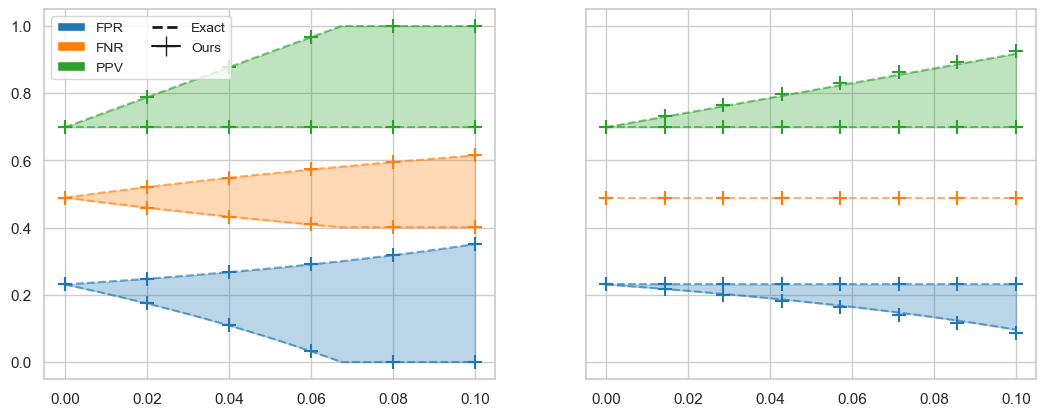

In [ ]:
fig

In [ ]:
alpha = 0.025
group=0
disparity_metric = "PPV"
optimiser="ipopt"
dag_type ="restricted"
op_group = 1 -group
proxy_equal = 1-alpha

dag = DAG()
# dag.from_structure("A -> Y, A->P, Y -> Z,P->Z")
if dag_type == "unrestricted":
    dag.from_structure("A -> Y, A->P, Y -> Z, U->P, U -> Y, V->P, V -> Z,A->Z", unob = "U,V")
else:
    dag.from_structure("A -> Y, A->P, Y -> Z, U->P, U -> Y,A->Z", unob = "U")
problem = causalProblem(dag)
problem.load_data(StringIO(prob_df.to_csv(index=False)))
numerator,denominator = get_numerator_denominator_fogliato(problem,metric=disparity_metric,group=group)
problem.set_estimand(numerator,div=denominator)
# problem.set_estimand(problem.query(f"Y=1&Z=0&A={group}&P=0"))
problem.add_constraint(problem.query("Y=0&Z=1"),symbol="==")
# problem.add_constraint(problem.query(f"Y=1&Z=0&A={op_group}"),symbol="==")
problem.add_constraint(problem.query(f"Y=1&Z=0&A={group}") - Query(alpha),symbol="<=")
program = problem.write_program()
result = program.run_pyomo('ipopt',verbose=False)
result

/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
/Users/jake/miniconda3/envs/couenne_env/lib/python3.12/site-packages/autobound/causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

ValueError: Cannot load a SolverResults object with bad status: error

In [ ]:
M = pyo.ConcreteModel()
solver = pyo.SolverFactory('couenne')
for p in program.parameters:
    if p != 'objvar':
        setattr(M, p, pyo.Var(bounds = (0,1)))
    else:
        setattr(M, p, pyo.Var())
# Next loop is not elegant, needs refactoring
for i, c in enumerate(program.constraints):
    setattr(M, 'c' + str(i),
            pyo.Constraint(expr = 
                pyomo_symb[c[-1][0]](sum([ mult_params_pyomo(program.parameters, k, M ) for k in c[:-1] ]), 0)
            )
    )
program.M_upper = deepcopy(M)
program.M_lower = deepcopy(M)
program.M_upper.obj = pyo.Objective(expr = program.M_upper.objvar, sense = pyo.maximize)
program.M_lower.obj = pyo.Objective(expr = program.M_lower.objvar, sense = pyo.minimize)
solve1(solver,program.M_lower,'lower',True)
result = None

KeyboardInterrupt: 